In [1]:
import gc
import glob

import geopandas as gpd
import momepy as mm
import numpy as np
import pandas as pd
import shapely
from libpysal.graph import Graph, read_parquet
import datetime

regions_datadir = "/data/uscuni-ulce/"
data_dir = "/data/uscuni-ulce/processed_data/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")
graph_dir = data_dir + "neigh_graphs/"
chars_dir = "/data/uscuni-ulce/processed_data/chars/"

In [2]:
## to build a new conda env
## conda install -c conda-forge momepy umap-learn fast_hdbscan jupyterlab pyarrow matplotlib lonboard folium mapclassify datashader bokeh holoviews dask
# pip install -e . for shapely, momepy, core, geoplanar, fast_hdbscan

In [3]:
osm_ids = ['v0.1-DEU.9.8.13.1_1-194', 'v0.1-DEU.9.8.13.1_1-232',
       'v0.1-DEU.9.8.13.1_1-214', 'v0.1-DEU.9.8.13.1_1-273',
       'v0.1-DEU.9.8.13.1_1-211', 'v0.1-DEU.9.8.13.1_1-188',
       'v0.1-DEU.9.8.13.1_1-192', 'v0.1-DEU.9.8.13.1_1-276',
       'v0.1-DEU.9.8.13.1_1-191', 'v0.1-DEU.9.8.13.1_1-184',
       'v0.1-DEU.9.8.13.1_1-245', 'v0.1-DEU.9.8.13.1_1-275']

In [4]:
region_name = 69300

In [5]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "regions_hull.parquet"
    )

In [6]:
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

In [7]:
## need to link eubucco building polygons to regions, this will change in the future
building_region_mapping = pd.read_parquet(
    regions_datadir + "regions/" + "id_to_region.parquet", engine="pyarrow"
)
typed_dict = pd.Series(
    np.arange(building_region_mapping["id"].values.shape[0]),
    index=building_region_mapping["id"].values,
)
region_ids = building_region_mapping.groupby("region")["id"].unique()
del building_region_mapping  # its 2/3 gb

## Streets

In [8]:
from core.generate_streets import process_region_streets

In [9]:
## overture is indexed based on 4326
overture_hull = region_hulls.loc[[region_name], ].to_crs(epsg=4326).convex_hull.iloc[0]

In [10]:
%%time
## processs streets
streets = process_region_streets(overture_hull, region_id)
## save streets
streets.to_parquet(data_dir + f"streets/streets_{region_id}.parquet")

/home/krasen/urban_taxonomy/core/generate_streets.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]


CPU times: user 3.05 s, sys: 1.92 s, total: 4.97 s
Wall time: 2min 23s


<Axes: >

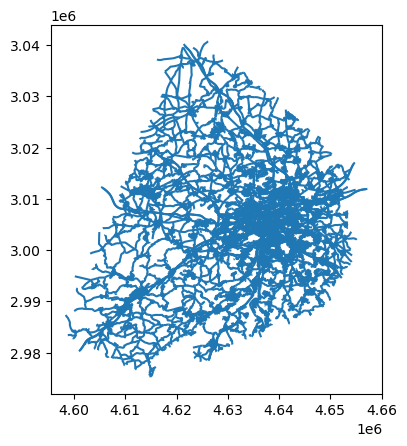

In [11]:
streets.plot()

## Buildings


In [12]:
from core.generate_buildings import read_region_buildings, process_region_buildings

In [13]:
%%time

buildings = read_region_buildings(
    typed_dict, region_ids, region_hull, region_id
)

buildings = process_region_buildings(buildings, True, simplification_tolerance=.1, merge_limit=25)

buildings.to_parquet(data_dir + f"buildings/buildings_{region_id}.parquet")

Percent polygons:  0.9999199709227686
Final polygons:  299065 , dropped:  0.05934879566199269
CPU times: user 1min 45s, sys: 981 ms, total: 1min 46s
Wall time: 1min 48s


## Enclosures & Tessellation

In [14]:
from core.generate_elements import process_region_elements

In [15]:
%%time
enclosures, tesselations = process_region_elements(region_id)

enclosures.to_parquet(data_dir + f"enclosures/enclosure_{region_id}.parquet")
print("Processed enclosures")

## save files
tesselations.to_parquet(
    data_dir + f"tessellations/tessellation_{region_id}.parquet"
)
print("processed tesselations")

---- Processing region:  69300 2024-07-16 17:29:03.218083
Retrying tesselation with less buildings, potentially changing building data.
Dropping 1 buildings due to tesselation problems
Processed enclosures
processed tesselations
CPU times: user 1min 46s, sys: 4.15 s, total: 1min 50s
Wall time: 2min 40s


## Graphs

In [16]:
from core.generate_ngraphs import process_region_graphs

In [17]:
%%time
process_region_graphs(region_id)

Built tess graph knn=1
Built buildings graph knn=1
Built streets graph knn=1
Built enclosure graph knn=1


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 304 disconnected components.
  w = W(neighbors, weights, ids, silence_warnings=silence_warnings)


Built nodes graph knn=1
CPU times: user 33.1 s, sys: 513 ms, total: 33.6 s
Wall time: 33.5 s


## Characters

In [7]:
from core.generate_chars import process_single_region_chars

In [8]:
%%time
process_single_region_chars(region_id)

2024-07-16 17:33:09.128794 ----Processing ------ 69300
Processing streets


/home/krasen/momepy/momepy/functional/_diversity.py:73: RuntimeWarning: invalid value encountered in cast
  ).values.astype(bool)


Processing enclosures
Processing buildings


/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:576: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(90 - degrees[true_angles]))
/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:737: RuntimeWarning: Mean of empty slice
  return Series({"mean": np.nanmean(dists), "std": np.nanstd(dists)})
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:890: 

Processing tessellation
CPU times: user 8min 7s, sys: 4.3 s, total: 8min 12s
Wall time: 8min 10s


## Generate primary data

In [9]:
tessellation = gpd.read_parquet(chars_dir + f"tessellations/chars_{region_id}.parquet")
buildings = gpd.read_parquet(chars_dir + f"buildings/chars_{region_id}.parquet")
enclosures = gpd.read_parquet(chars_dir + f"enclosures/chars_{region_id}.parquet")
streets = gpd.read_parquet(chars_dir + f"streets/chars_{region_id}.parquet")
nodes = gpd.read_parquet(chars_dir + f"nodes/chars_{region_id}.parquet")


merged = pd.merge(
    tessellation.drop(columns=["geometry"]),
    buildings.drop(columns=["nodeID", "geometry", 'nID']),
    right_index=True,
    left_index=True,
    how="left",
)

merged = merged.merge(
    enclosures.drop(columns="geometry"),
    right_on="eID",
    left_on="enclosure_index",
    how="left",
)

merged = merged.merge(streets.drop(columns="geometry"), on="nID", how="left")
merged = merged.merge(nodes.drop(columns="geometry"), on="nodeID", how="left")

merged = merged.drop(
    columns=[
        "nID",
        "eID",
        "nodeID",
        "mm_len",
        "cdsbool",
        "node_start",
        "node_end",
        "x",
        "y",
        "enclosure_index",
        # "id",
        # "osm_id",
        "index",  ## maybe keep
    ]
)
merged = merged.set_index(tessellation.index)

In [10]:
from core.utils import used_keys

In [11]:
primary = merged[list(used_keys.keys())]
primary.shape

(315293, 62)

In [12]:
primary.to_parquet(chars_dir + f'primary_chars/primary_chars_{region_id}.parquet')

In [14]:
# buildings.explore()

In [13]:
region_id = 69300

In [14]:
from core.generate_chars import process_enclosure_chars, process_building_chars, process_tessellation_chars, process_street_chars
# process_street_chars(69300)
# process_enclosure_chars(69300)
# process_building_chars(69300)
process_tessellation_chars(69300)

Processing tessellation


In [ ]:
# tessellation = gpd.read_parquet(
#         data_dir + f"tessellations/tessellation_{69300}.parquet"
#     )

# # import lonboard
# # # layer = lonboard.PolygonLayer.from_geopandas(tessellation, opacity=0.15)
# # # m = lonboard.Map([layer])
# # # m

In [25]:
from core.generate_streets import read_overture_region_streets, rp

In [34]:
streets = read_overture_region_streets(region_hulls.loc[[region_name]].to_crs(epsg=4326).iloc[0].convex_hull, region_id)

In [76]:
orig_streets = streets

In [92]:
approved_roads = ['living_street',
                 'motorway',
                 'motorway_link',
                 'pedestrian',
                 'primary',
                 'primary_link',
                 'residential',
                 'secondary',
                 'secondary_link',
                 'tertiary',
                 'tertiary_link',
                 'trunk',
                 'trunk_link',
                 'unclassified']
streets = orig_streets[orig_streets['class'].isin(approved_roads)]
## drop tunnels
streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]
streets = streets.set_crs(epsg=4326).to_crs(epsg=3035)
streets = streets.sort_values('id')[['id', 'geometry', 'class']].reset_index(drop=True)

/tmp/ipykernel_784467/2213379909.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]


In [94]:
plotting = streets.reset_index()

In [95]:
import lonboard

In [96]:
layer = lonboard.PathLayer.from_geopandas(plotting, width_min_pixels=1)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [97]:
m = lonboard.Map(layer)
m

Map(layers=[PathLayer(table=pyarrow.Table
index: uint16
id: string
class: string
geometry: list<item: fixed_si…

In [82]:
tunnel = streets.loc[[41318, 41316]]

/tmp/ipykernel_784467/3077578378.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets[~streets.road.str.contains('is_tunnel').fillna(False)]


,id,geometry,class,road
0,0821e37fffffffff0477ae0e1bed1e9a,"LINESTRING (4611749.424 3004369.263, 4611780.6...",residential,None
1,0821e37fffffffff047bbe5677a74480,"LINESTRING (4611714.139 3004739.97, 4611787.46...",residential,None
2,0821e37fffffffff047bfb8fac33b4c9,"LINESTRING (4611567.93 3004432.278, 4611694.70...",residential,None
3,0821e37fffffffff047fa869f63e10e7,"LINESTRING (4611467.748 3004340, 4611448.418 3...",secondary,"{""restrictions"":{""speed_limits"":[{""max_speed"":..."
4,0821e37fffffffff047fff5f666d5099,"LINESTRING (4611372.18 3006808.012, 4611455.43...",tertiary,None
...,...,...,...,...
59854,08e1e354e35110570477ffeef2f023b4,"LINESTRING (4645687.693 3003560.862, 4645689.7...",tertiary,"{""surface"":[{""value"":""paved""}],""flags"":[{""valu..."
59855,08e1e354e62e2ac70477ff140f503231,"LINESTRING (4643777.747 3005180.047, 4643778.1...",tertiary,"{""surface"":[{""value"":""paved""}],""restrictions"":..."
59856,08e1e354e68de297047befce7622274c,"LINESTRING (4642665.336 3005942.733, 4642662.6...",secondary,"{""surface"":[{""value"":""paved""}],""restrictions"":..."
59857,08e1e354f40a18a7047bffd7edee26e0,"LINESTRING (4639107.972 3002845.339, 4639107.8...",residential,"{""surface"":[{""value"":""paved""}],""restrictions"":..."
